In [8]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np 
import scipy
from scipy import integrate, stats
from numpy import linalg

from scipy.special import gammaln


import torch
import time



import generate_data as gd


# change to whatever directory you have set up :) 
path_to_directory = './training_data_rt/'

# Generating Data

First, generate a number of parameter vectors randomnly spaced in log space. Or, load in pre-stored parameter vectors. Exponentiate them to calculate CME (although log10 of the values will be stored to train on). 

In [2]:
# EITHER generate

N = 512000
param_vectors = gd.generate_param_vectors(N)

# can save np.save('/path/to/parameters',param_vectors)

# OR load in 
# param_vectors = np.load('/path/to/parameters.npy',allow_pickle=True)

param_vectors = 10**param_vectors

Best to change `generate_sets` so it doesn't have to take in a `generate_kernel` function. Later!

In [3]:

# here are the functions to play around with!! 

def generate_grid(npdf,VAR,MU,method='logn',quantiles='lin'):
    if quantiles=='lin':
        q = np.linspace(0,1,npdf+2)[1:-1]
    elif quantiles=='cheb':
        n = np.arange(npdf)
        q = (np.cos((2*(n+1)-1)/(2*npdf)*np.pi)+1)/2
    elif quantiles=='PRESET':
        logstd = np.sqrt(np.log((VAR/MU**2)+1))
        logmean = np.log(MU**2/np.sqrt(VAR+MU**2))
        translin = np.exp(logmean+logstd*NORM)
        return translin
    if method == 'logn': #if you want to use other basis function samples, generate ur own 
        norm = stats.norm.ppf(q)
        logstd = np.sqrt(np.log((VAR/MU**2)+1))
        logmean = np.log(MU**2/np.sqrt(VAR+MU**2))
        translin = np.exp(logmean+logstd*norm)
    if method=='lin':
        translin=q*(MU+3*np.sqrt(VAR))
    # print(translin)
    return translin




def generate_kernel(p,npdf,hyp=2.4, calc_method = 'log', grid_method='logn', ax = None,kernel='nb',quantiles='lin'):
    MU, VAR, STD, xmax = gd.get_moments(p)
    grid = generate_grid(npdf,VAR,MU,method=grid_method,quantiles=quantiles)
    if ax:
        ax.scatter(grid,np.zeros(npdf),c='k',s=20)
    s = hyp*np.insert(np.diff(grid), 0, grid[0])
    r = (grid/s)**2 
    p = 1/(1+s**2/grid)
    Y = np.zeros((xmax+1,npdf))
    xgrid = np.arange(xmax+1) 

    if kernel == 'nb':
        if calc_method=='log':
            for i in range(npdf):
                Y[:,i] = gammaln(xgrid+r[i]) - gammaln(xgrid+1) - gammaln(r[i]) + xgrid*np.log(1-p[i]) + r[i]*np.log(p[i])
            Y = np.exp(Y) 
    return Y



## Generate and Save Training/Testing Data
Now, to generate and save parameter, kernel, exact solution sets! Sets will be saved in 'path_to_directory.'

*File Names:* As an examlple of how files are named, a set size (or amount of param vectors per file) of 5,120 parameter vectors with 10 kernel (basis) functions would be saved as:

* '5120_0_ker_10.npy'
* '5120_1_ker_10.npy'
* '5120_2_ker_10.npy'
* ...


The number of files saved is data_size/set_size. Set size of 5,120 works well for downstream training. 

store_kernels can be set to True or False. 

In the first case, param_vectors, kernels, and exact solutions will be stored in a list of lists:  [ [param0, y_kernels0, y_exact0], [param1, y_kernels1, y_exact1], ... ] 

In the second case, param vectors and exact solutions only will be stored:  [ [param0, y_exact0], [ param1, y_exact1], ... ]


**If you only want to store parameter vectors and exact solutions, remember to set store_kernels to False**

In [4]:
# !mkdir -p 

Takes 10 seconds for `fixed_quad`. How long for `quad_vec`? _Much_ longer; 15 min.

they actually give nearly identical results. Might be good to parallelize if we use `quad_vec` in prod.

In [6]:
# gd.generate_sets(set_size,npdf,data_size,path_to_directory,param_vectors,store_kernels)
t1 = time.time()
gd.generate_sets(5120,10,512000,path_to_directory,param_vectors,generate_kernel,
                 store_kernels=False,cme_method='fixed_quad')
t2 = time.time()
print(t2-t1)

0


/home/ggorin/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
106.02057814598083


In [7]:
# gd.generate_sets?

----

# Training! 

Great, now you have some training data saved. It's time to **choose your own adventure**:
1. Train with MLP1 or MLP2?
2. Train with pregenerated kernels or to train generating the kernels at run time? 

Four different modules (fairly similar with a few differences) are written:

Pregenerated kernels:
* train_MLP1
* train_MLP2

Run-time generated kernels:
* train_MLP1_rt
* train_MLP2_rt

---

# Generate Kernels at RunTime Training

If you choose rather to proceed instead with generating kernel functions at runtime, pop in here! 

Below are the grid and kernel generating functions you can adjust! 

MLP1 and MLP2 architectures should be unified into a single function.

In [6]:
import train_MLP1_rt as rt1

# or import train_MLP2_rt  as rt2

In [78]:
def generate_grid(npdf,VAR,MU,method='logn',quantiles='PRESET'):
    
    if quantiles=='PRESET':
        logstd = torch.sqrt(np.log((VAR/MU**2)+1))
        logmean = torch.log(MU**2/np.sqrt(VAR+MU**2))
        translin = torch.exp(logmean+logstd*NORM)
        return(translin)
    elif quantiles=='lin':
        q = np.linspace(0,1,npdf+2)[1:-1]
    elif quantiles=='cheb':
        n = np.arange(npdf)
        q = (np.cos((2*(n+1)-1)/(2*npdf)*np.pi)+1)/2
    if method == 'logn': #if you want to use other basis function samples, generate ur own 
        norm = stats.norm.ppf(q)
        logstd = np.sqrt(np.log((VAR/MU**2)+1))
        logmean = np.log(MU**2/np.sqrt(VAR+MU**2))
        translin = np.exp(logmean+logstd*norm)
    if method=='lin':
        translin=q*(MU+3*np.sqrt(VAR))
    # print(translin)
    return translin


# def get_ypred_at_RT(p,npdf,w,hyp=2.4,grid_method='logn',quantiles='PRESET',
#                     zs=False,first_special=True,special_std='mean',
#                     basis_pmf ='nb'):
#     '''Given a parameter vector (tensor) and weights (tensor), 
#     calculates ypred (Y) at runtime.'''
    
#     p = 10**p
# #     p = torch.tensor(10**p)
#     MU, VAR, STD, xmax = rt1.get_moments(p)
    
#     grid = generate_grid(npdf,VAR,MU,method=grid_method,quantiles=quantiles)
#     if zs:
#         s = torch.zeros(npdf-1)
#     else:
#         s = torch.zeros(npdf)
    
#     spec = 0 if first_special else -1
#     if first_special:
#         s[1:] = torch.diff(grid)
#         spec = 0
#     else: #last special... for now
#         s[:-1] = torch.diff(grid)
#         spec = -1
    
    
#     if special_std == 'mean':
#         s[spec] = grid[spec]
#     elif special_std == 'neighbor': #assign_neighbor_to_special
#         s[spec] = s[1] if first_special else s[-2]
#     elif special_std == 'neighbor50':
#         s[spec] = s[1]/2 if first_special else s[-2]*1.5
#     elif special_std == 'tail_prob':
# #         print(type(p))
#         t_max = torch.log(p[1]/p[2])/(p[1] - p[2])
#         f = (torch.exp(-p[2]*t_max) - torch.exp(-p[1]*t_max)) * p[1]/(p[1] - p[2]) * p[0]
#         tailratio = 1/(1+1/f)
#         s[spec] = torch.sqrt(grid[spec] / (1-tailratio))
# #         print('hello')
# #         print(s[spec])

#     s *= hyp
#     v = s**2
#     v = torch.maximum(v,grid)
#     r = grid**2/(v-grid)
#     p = 1-grid/v
#     xgrid = torch.arange(xmax+1)
#     Y = torch.zeros(xmax+1)
#     GAMMALN_XGRID = lnfactorial[1:(len(xgrid)+1)]
#     if zs: #use zero spike
#         Y[0] = w[-1]
#     for i in range(len(s)):
#         if basis_pmf == 'nb':
#             if p[i] >1e-10:
#                 l = torch.special.gammaln(xgrid+r[i]) - GAMMALN_XGRID - torch.special.gammaln(r[i]) + xgrid*torch.log(p[i]) + r[i]*torch.log(1-p[i])
#             else:
#                 l = -grid[i] + xgrid * torch.log(grid[i]) - GAMMALN_XGRID
#         elif basis_pmf =='poisson':
#             l = -grid[i] + xgrid * torch.log(grid[i]) - GAMMALN_XGRID
#         Y += w[i]*torch.exp(l)
# #     Y[Y<1e-30]=1e-30
#     return Y

In [79]:
# def get_ypred_at_RT(p,npdf,w,hyp=2.4,grid_method='logn',quantiles='PRESET',
#                     zs=False,first_special=True,special_std='mean',
#                     basis_pmf ='nb'):
#     '''Given a parameter vector (tensor) and weights (tensor), 
#     calculates ypred (Y) at runtime.'''
    
#     p = 10**p
#     MU, VAR, STD, xmax = rt1.get_moments(p)
    
#     grid = generate_grid(npdf,VAR,MU,method=grid_method,quantiles=quantiles)
# #     if zs:
# #         s = torch.zeros(npdf-1)
# #     else:
# #         s = torch.zeros(npdf)
    
# #     grid = generate_grid(npdf,VAR,MU,method=grid_method,quantiles=quantiles)

#     t_max = torch.log(p[1]/p[2])/(p[1] - p[2])
#     f = (torch.exp(-p[2]*t_max) - torch.exp(-p[1]*t_max)) * p[1]/(p[1] - p[2]) * p[0]
#     tailratio = 1/(1+1/f)
#     s =  torch.sqrt(grid / (1-tailratio))

#     v = s**2
#     r = grid**2/(v-grid)
#     p = 1-grid/v
# #     spec = 0 if first_special else -1
# #     if first_special:
# #         s[1:] = torch.diff(grid)
# #         spec = 0
# #     else: #last special... for now
# #         s[:-1] = torch.diff(grid)
# #         spec = -1
    
    
# #     if special_std == 'mean':
# #         s[spec] = grid[spec]
# #     elif special_std == 'neighbor': #assign_neighbor_to_special
# #         s[spec] = s[1] if first_special else s[-2]
# #     elif special_std == 'neighbor50':
# #         s[spec] = s[1]/2 if first_special else s[-2]*1.5
# #     elif special_std == 'tail_prob':
# #         t_max = torch.log(p[1]/p[2])/(p[1] - p[2])
# #         f = (torch.exp(-p[2]*t_max) - torch.exp(-p[1]*t_max)) * p[1]/(p[1] - p[2]) * p[0]
# #         tailratio = 1/(1+1/f)
# #         s[spec] = torch.sqrt(grid[spec] / (1-tailratio))
# #     else:
# #         print('did not specify a standard deviation convention!')

# #     s *= hyp
# #     v = s**2
# # #     v = torch.maximum(v,grid)
# #     r = grid**2/(v-grid)
# #     p = 1-grid/v
# #     theta = p/(1-p)
#     xgrid = torch.arange(xmax+1)
#     Y = torch.zeros(xmax+1)
#     GAMMALN_XGRID = lnfactorial[1:(len(xgrid)+1)]
#     if zs: #use zero spike
#         Y[0] = w[-1]
#     for i in range(len(s)):
#         if basis_pmf == 'nb':
#             l = -grid[i] + xgrid * torch.log(grid[i]) - GAMMALN_XGRID
# #             print(p[i].dtype)
# #             print(torch.zeros(1).float().dtype)
#             if p[i] >1e-10:
#                 l += torch.special.gammaln(xgrid+r[i]) - torch.special.gammaln(r[i]) \
#                     - xgrid*torch.log(r[i] + grid[i]) + grid[i] \
#                     + r[i]*torch.log(1-p[i])
# #             print(l)
# #              torch.heaviside(p[i],torch.zeros(1,dtype=p[i].dtype)) * 
# #             if p[i] >1e-10:
# #                 l = torch.special.gammaln(xgrid+r[i]) - GAMMALN_XGRID - torch.special.gammaln(r[i]) + xgrid*torch.log(p[i]) + r[i]*torch.log(1-p[i])
# #             else:
# #                 l = -grid[i] + xgrid * torch.log(grid[i]) - GAMMALN_XGRID
# #         elif basis_pmf =='poisson':
# #             l = -grid[i] + xgrid * torch.log(grid[i]) - GAMMALN_XGRID
#         Y += w[i]*torch.exp(l)
# #     Y[Y<1e-30]=1e-30
#     return Y

In [80]:
def get_ypred_at_RT(p,npdf,w,hyp=2.4,grid_method='logn',quantiles='PRESET',
                    zs=False,first_special=True,special_std='mean',
                    basis_pmf ='nb'):
    '''Given a parameter vector (tensor) and weights (tensor), 
    calculates ypred (Y) at runtime.'''
    
    p = 10**p
    MU, VAR, STD, xmax = rt1.get_moments(p)
    
    grid = generate_grid(npdf,VAR,MU,method=grid_method,quantiles=quantiles)

    t_max = torch.log(p[1]/p[2])/(p[1] - p[2])
    f = (torch.exp(-p[2]*t_max) - torch.exp(-p[1]*t_max)) * p[1]/(p[1] - p[2]) * p[0]
    tailratio = 1/(1+1/f)
    s =  torch.sqrt(grid / (1-tailratio))

    v = s**2
    r = grid**2/(v-grid)
    p = 1-grid/v
    
    xgrid = torch.arange(xmax+1)
    Y = torch.zeros(xmax+1)
    GAMMALN_XGRID = lnfactorial[1:(len(xgrid)+1)]
    if zs: #use zero spike
        Y[0] = w[-1]
    for i in range(len(s)):
        if basis_pmf == 'nb':
            l = -grid[i] + xgrid * torch.log(grid[i]) - GAMMALN_XGRID
            if p[i] >1e-10:
                l += torch.special.gammaln(xgrid+r[i]) - torch.special.gammaln(r[i]) \
                    - xgrid*torch.log(r[i] + grid[i]) + grid[i] \
                    + r[i]*torch.log(1-p[i])
        Y += w[i]*torch.exp(l)
    return Y

In [11]:
torch.nn.ReLU(10)

ReLU(inplace=True)

In [81]:
# define NORM and precalculate factorials - change the npdf if not using 10 kernel functions

npdf = 5

# predefine NORM
#linear uniform
# q = np.linspace(0,1,npdf+1)[1:-1]
q = np.linspace(0,1,npdf+2)[1:-1]
# NORM = stats.norm.ppf(q)
# NORM = torch.tensor(NORM) 

#chebyshev
n = np.arange(npdf)
# q = np.flip((np.cos((2*(n+1)-1)/(2*npdf)*np.pi)+1)/2)

#gauss-legendre
# q = (scipy.special.roots_legendre(npdf)[0]+1)/2

#other chebyshev
# q = (scipy.special.roots_chebyu(npdf)[0]+1)/2

#yet another chebyshev
# q = (scipy.special.roots_chebyc(npdf)[0]+1)/2

NORM = stats.norm.ppf(q)
NORM = torch.tensor(NORM)


# precalculate lngammas
lnfactorial = torch.special.gammaln(torch.arange(1003))

**Load in the training data, testing data that DOES NOT have kernel functions stored. I would store in a different directory.** 



In [82]:
path_to_directory = './training_data_rt/'

# get_data(npdf,number_of_training_files,number_of_testing_files,number_total_files,path):
# train_list,test_list = rt1.get_data(10,8,2,number_total_files=10,path=path_to_directory)
train_list,test_list = rt1.get_data(10,8,2,number_total_files=10,path=path_to_directory)

In [83]:
test_list[0][1].dtype

dtype('float64')

And Train!!

There is a new interface that allows for zero spikes (in which case, `NORM` has to be defined with `npdf+1` rather than `npdf+2`), some options re: which edge state is "special".

Trying some stuff with optimizing for `maxabsdev`, then testing KLD performance. 

Use these if you do not want to learn hyp.

In [84]:
YPRED_FUN = lambda p, npdf, w: get_ypred_at_RT(p=p,npdf=npdf,w=w,hyp=2.4,
                                               grid_method='logn',quantiles='PRESET',
                                               zs=False,first_special=False,
                                               special_std='tail_prob',basis_pmf='nb')


In [86]:
time1 = time.time()

#vanilla definition: lognormal, precomputed quantiles, no zerospike, first basis is special, & is assigned its mean as its stdev.
#                                                special_std='neighbor',basis_pmf='nb')
# YPRED_FUN = lambda p, npdf, w: get_ypred_at_RT(p=p,npdf=npdf,w=w,hyp=2.4,grid_method='logn',quantiles='PRESET',zs=True,first_special=True,special_std='mean')

e,b,t,model = rt1.train_MLP1(train_list,test_list,num_epochs=15,npdf=npdf,batchsize=512,learning_rate=1e-3,
                     metric='kld',get_ypred_at_RT = YPRED_FUN,fit_hyp=False)

# e,b,t,model = rt1.train_MLP1(train_list,test_list,num_epochs=2,npdf=10,batchsize=512,learning_rate=1e-3,
#                      metric='kld',get_ypred_at_RT = get_ypred_at_RT)

time2 = time.time()
print(time2-time1)

Epoch Number: 0
Epoch Number: 1
Epoch Number: 2
Epoch Number: 3
Epoch Number: 4
Epoch Number: 5
Epoch Number: 6
Epoch Number: 7
Epoch Number: 8
Epoch Number: 9
Epoch Number: 10
Epoch Number: 11
Epoch Number: 12
Epoch Number: 13
Epoch Number: 14
857.8854792118073


In [ ]:
test

Use these if you do want to learn hyp.

In [16]:
# YPRED_FUN = lambda p, npdf, w, hyp: get_ypred_at_RT(p=p,npdf=npdf,w=w,hyp=hyp,
#                                                grid_method='logn',quantiles='PRESET',
#                                                zs=False,first_special=False,
#                                                special_std='tail_prob',basis_pmf='nb')

In [17]:
# time1 = time.time()

# #vanilla definition: lognormal, precomputed quantiles, no zerospike, first basis is special, & is assigned its mean as its stdev.
# #                                                special_std='neighbor',basis_pmf='nb')
# # YPRED_FUN = lambda p, npdf, w: get_ypred_at_RT(p=p,npdf=npdf,w=w,hyp=2.4,grid_method='logn',quantiles='PRESET',zs=True,first_special=True,special_std='mean')

# e,b,t,model = rt1.train_MLP1(train_list,test_list,num_epochs=2,npdf=npdf,batchsize=512,learning_rate=1e-3,
#                      metric='kld',get_ypred_at_RT = YPRED_FUN,fit_hyp=True)

# # e,b,t,model = rt1.train_MLP1(train_list,test_list,num_epochs=2,npdf=10,batchsize=512,learning_rate=1e-3,
# #                      metric='kld',get_ypred_at_RT = get_ypred_at_RT)

# time2 = time.time()
# print(time2-time1)

Epoch Number: 0
Epoch Number: 1
98.45009279251099


---

# Validation: Plotting, plotting


If you are using generated at rt, import tools_1D_rt.

If you using pregenerated kernels, import tools_1D

In [ ]:
import tools_1D_rt as tt

# or import tools_1D as tp if you trained with pre-generated kernels



Various annoying debug things. Mean of truncated distribution is not mean of the full distribution, because of course it's not.

In [ ]:
# model.forward(p_s)

In [ ]:
# 10**train_list[0][0]

In [ ]:
# w_pred

In [ ]:
model = rt1.my_MLP1(3,npdf,True)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [ ]:
model.train()

In [ ]:
parameters,y_list = rt1.shuffle_training_data(train_list)

In [ ]:
optimizer.zero_grad()

In [ ]:
j=0

In [ ]:
batchsize=512
i = j * batchsize
p = parameters[i:i+batchsize]
y = y_list[i:i+batchsize]


In [ ]:
w_pred = model(p)

In [ ]:
w_pred

In [ ]:
w_pred.cumsum(1

In [ ]:
model[]

In [ ]:
p_s = torch.tensor(np.asarray([test_list[0][0]])).float()


In [ ]:
p_s

In [ ]:
model.forward(p_s)

In [ ]:
ww=model.forward(p_s)[0]
plt.plot(YPRED_FUN(p_s[0],npdf,ww[:-1],ww[-1]).detach().numpy(),'g-')

plt.plot(test_list[0][1],'k--')


In [ ]:
p_s = torch.tensor(np.asarray([train_list[0][0]])).float()


In [ ]:
plt.plot(YPRED_FUN(p_s[0],npdf,model.forward(p_s)[0]).detach().numpy(),'g-')

plt.plot(train_list[0][1],'k--')


In [ ]:

param = 10**train_list[0][0]
MU, VAR, STD, xmax = rt1.get_moments(param)

grid = generate_grid(npdf,VAR,MU)

In [ ]:
param

In [ ]:
param[0]/param[2]

In [ ]:
sum(train_list[0][1]* np.arange(xmax+1)**2)-MU**2

In [ ]:
sum(train_list[0][1]* np.arange(xmax+1))

In [ ]:
np.dot(train_list[0][1],np.arange(xmax+1))

In [ ]:
plt.plot(np.arange(xmax+1),train_list[0][1])
plt.yscale('log')

In [ ]:
MU

In [ ]:
STD

In [ ]:
(VAR)

In [ ]:
MU

I suspect that even if a non-KLD metric is passed in at the `train_MLP1` stage, the test set has KLD applied to it. Need to double-check how it's computed.

In [65]:
t

[inf, inf, inf, inf, inf]

$>5$ epochs is gross overkill.

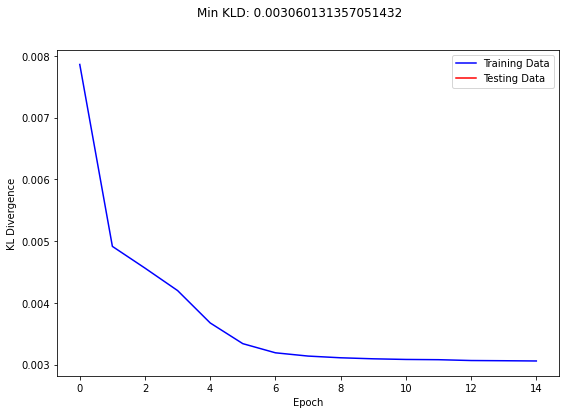

In [87]:
# kld over epochs
tt.plot_training(e,t)

Calculate KLDs for all parameter values in training data with the trained model.

### KLD histogram, CDF

In [88]:
# OR klds, mean_kld = tm1.calculate_test_klds(train_list,model)
klds,mean_kld = rt1.calculate_test_klds(train_list,npdf,model,get_ypred_at_RT=YPRED_FUN,)
# klds,mean_kld = rt1.calculate_test_klds(test_list,npdf,model,get_ypred_at_RT)

In [107]:
klds,mean_kld = rt1.calculate_test_klds(test_list,npdf,model,get_ypred_at_RT=YPRED_FUN,)


In [108]:
i__ = np.where(~np.isfinite(klds))[0][0]

In [91]:
# klds

Text(0.5, 1.0, 'MLP1')

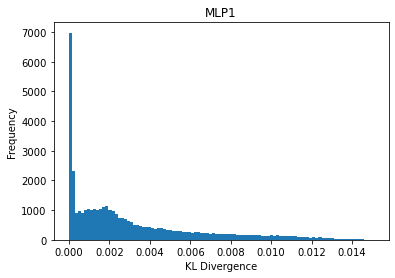

In [92]:
# kld value histogram 

# OR tp.plot_histogram(klds,bins=100)

tt.plot_histogram(klds,bins=100)
plt.title('MLP1')

In [93]:
np.quantile(klds,[0,0.25,0.5,0.75,1])

array([1.40247863e-07, 4.59388917e-04, 1.96670019e-03, 4.54919483e-03,
       1.50490403e-02])

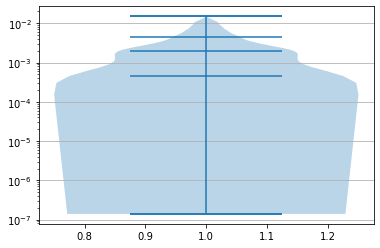

In [94]:
plt.violinplot((klds),quantiles=[0,0.25,0.5,0.75,1])
plt.yscale('log')
plt.grid(axis='y')


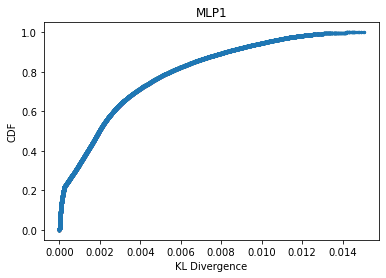

In [95]:
# kld value CDF
plt.title('MLP1')

# or tp.plot_CDF(klds)

tt.plot_CDF(klds)

### Random PMFs

Plotting nrow * ncols random PMFs from train_list (or test_list, whatever list you provide). 

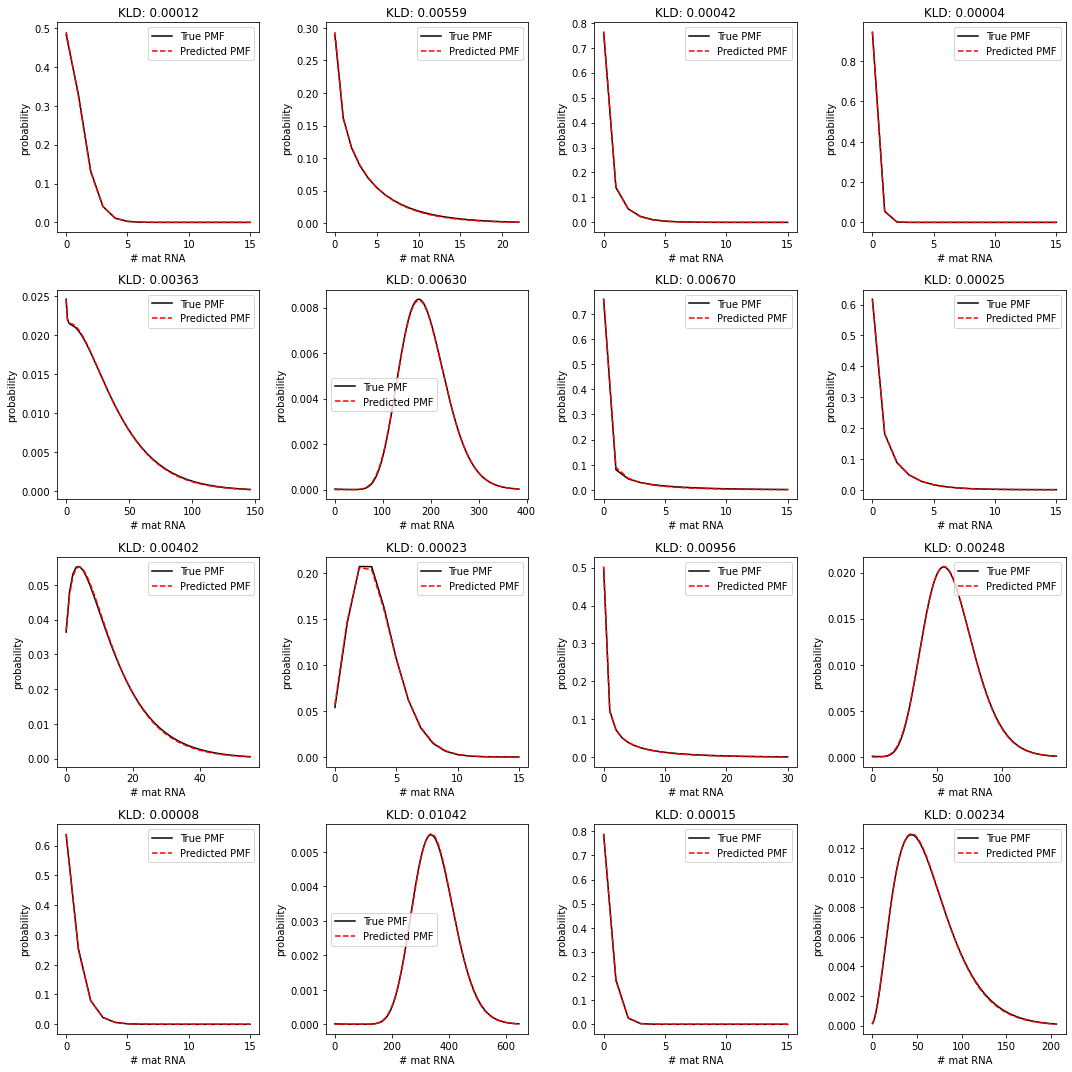

In [96]:
# OR tp.plot_PMF_grid(train_list,nrows,ncols,model)

# tt.plot_PMF_grid(test_list,npdf = 10,nrows=4,ncols=4,model=model,get_ypred_at_RT = get_ypred_at_RT,kld=True)
tt.plot_PMF_grid(train_list,npdf = npdf,nrows=4,ncols=4,model=model,get_ypred_at_RT = YPRED_FUN,kld=True)

### Parameters plotted by quantile.

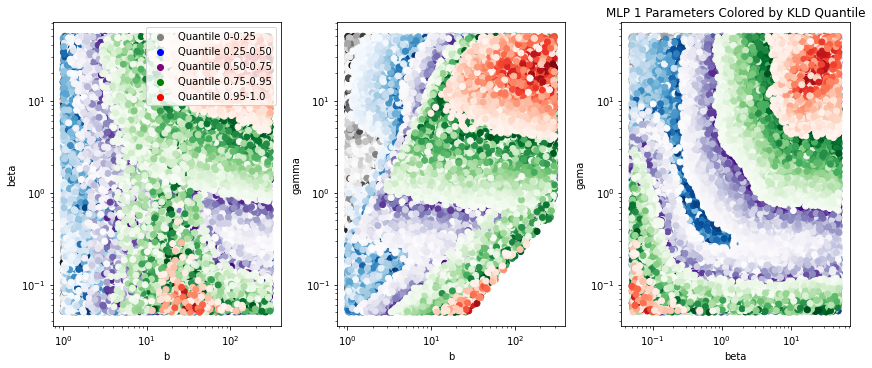

In [97]:
# tt.plot_param_quantiles(klds,test_list,model)
tt.plot_param_quantiles(klds,train_list,model)

In [98]:
klds.shape

(40960,)

In [99]:
nr = 5
nc = 5
N_ = nr*nc
I_ = np.argpartition(-klds,N_)[:N_]

In [100]:
train_list_subset = [train_list[i] for i in I_]

In [101]:
train_list_subset_p = np.asarray([train_list_subset[i][0] for i in range(N_)])

In [102]:
train_list_subset_p

array([[ 2.42970951,  1.35823262,  1.3639452 ],
       [ 2.45230519,  1.46356012,  1.39773255],
       [ 2.38930491,  1.35297849,  1.33670416],
       [ 2.34776523,  1.339017  ,  1.34497431],
       [ 2.29283196,  1.43482914,  1.40845455],
       [ 2.35641037,  1.25660876,  1.31790193],
       [ 2.30188006,  1.2858205 ,  1.23674074],
       [ 2.47478941,  1.32759363,  1.34954173],
       [ 2.41686597,  1.42623859,  1.3417532 ],
       [ 2.38633356,  1.37769298,  1.36716711],
       [ 2.35213631,  1.39887647,  1.30657248],
       [ 2.37486761,  1.37237519,  1.37271274],
       [ 2.46878194,  1.35099199,  1.36671172],
       [ 2.39599364,  1.31660726,  1.24435155],
       [ 2.44065402,  1.25870021,  1.35765224],
       [ 2.44083986,  1.34576033,  1.23374397],
       [ 2.46470785,  1.42529587,  1.31470403],
       [ 2.36201541,  1.30211896,  1.26498588],
       [ 2.4073562 ,  1.36097104,  1.23533491],
       [ 2.33903648,  1.46905026,  1.4038265 ],
       [ 2.24090699,  1.44079362,  1.395

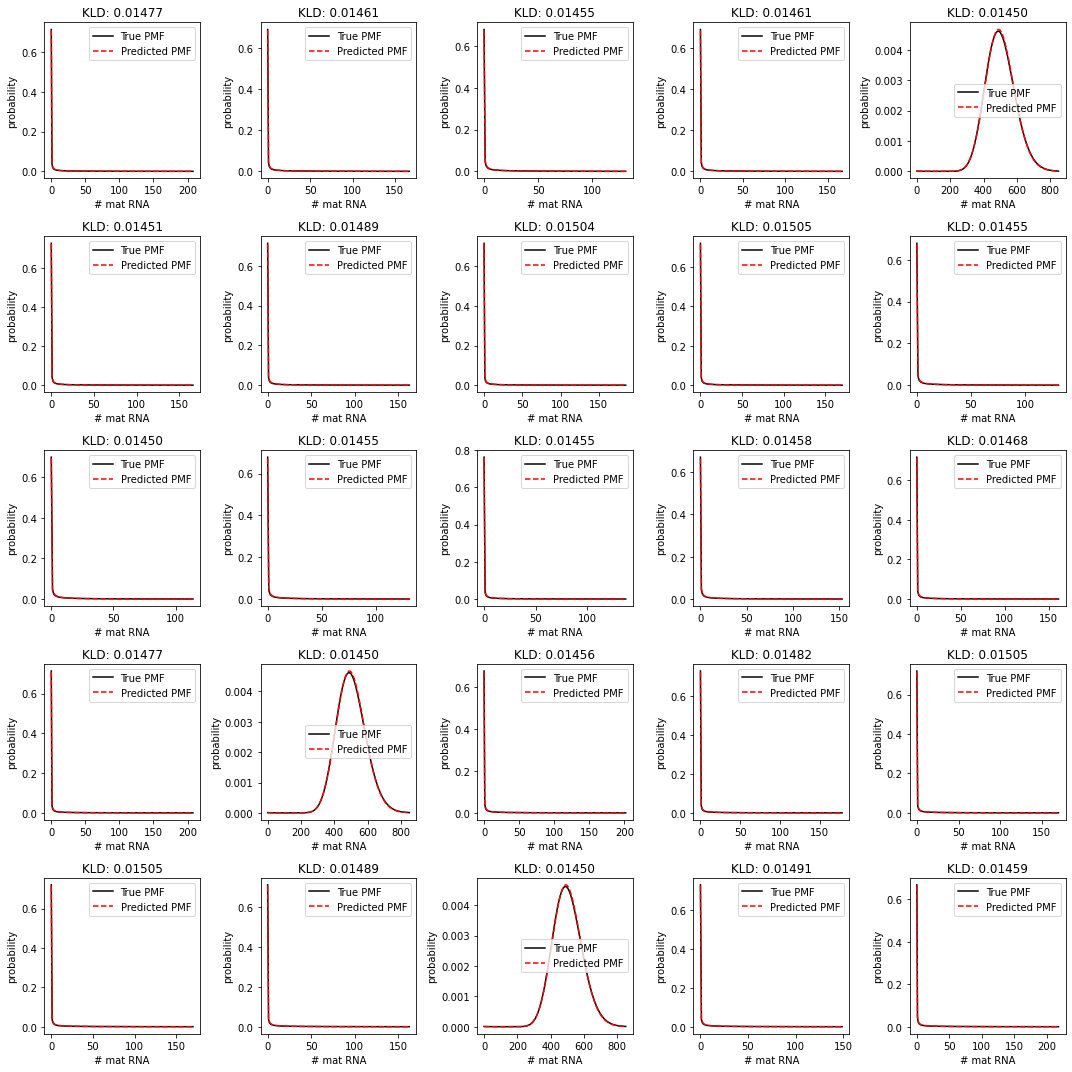

In [103]:
tt.plot_PMF_grid(train_list_subset,npdf = npdf,nrows=nr,ncols=nc,model=model,get_ypred_at_RT = YPRED_FUN,kld=True)

### Specific PMF

If you want to plot a specific parameter's PMF, you'll need to provide the parameter vector and the exact pmf histogram (as a list).

[0.7142232  0.04431462 0.02482863 0.01748548 0.01356772 0.01111037
 0.00941579 0.00817184 0.00721725 0.00646   ]
[0.7201523  0.03739536 0.02048007 0.01443346 0.01128347 0.00933426
 0.0080011  0.00702729 0.00628203 0.00569149]
171
weights
tensor([0.1677, 0.2715, 0.0556, 0.0239, 0.4813], grad_fn=<SelectBackward0>)


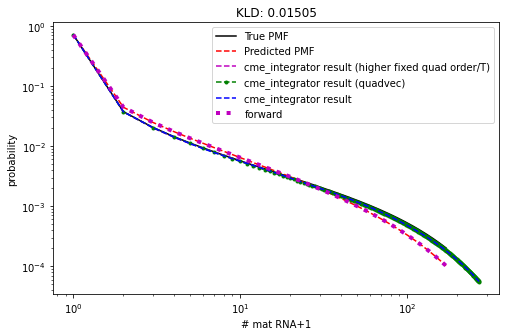

In [104]:
# as an example: 
param_list,y_list = rt1.load_training_data(train_list)


p1 = param_list[I_[0]:(I_[0]+1)]
y1 = [y_list[I_[0]]]


# tt.plot_PMF(p1,y1,model,npdf,get_ypred_at_RT,kld=True) 
ax = plot_PMF_(p1,y1,model,npdf,YPRED_FUN,kld=True)

# print(p1)
p1_lin = 10**np.asarray(p1[0])
MU, VAR, STD, xmax = gd.get_moments(p1_lin)

y = cme_integrator(p1_lin,xmax+100,quad_order=100,fixed_quad_T=30)
ax.plot(np.arange(len(y))+1,y,'m--',label='cme_integrator result (higher fixed quad order/T)')
y = cme_integrator(p1_lin,xmax+100,method='quad_vec')
ax.plot(np.arange(len(y))+1,y,'g.--',label='cme_integrator result (quadvec)')
y = cme_integrator(p1_lin,xmax+100)
ax.plot(np.arange(len(y))+1,y,'b--',label='cme_integrator result')

# print(y[0])
print('weights')
print(model.forward(p1)[0])
ax.plot(np.arange(xmax+1)+1,YPRED_FUN(p1[0],npdf,model.forward(p1)[0]).detach().numpy(),'m:',label='forward',linewidth=4)
_=ax.legend()

# gd.cme_integrator
# ax=plt.gca()
# g1 = plt.gca()
# g1.set_yscale('log')

[0.00000e+00 0.00000e+00 0.00000e+00 5.60519e-45 6.58610e-44 5.81539e-43
 4.40708e-42 2.91820e-41 1.72423e-40 9.23052e-40]
[7.6583765e-06 7.4390309e-06 7.2256180e-06 7.0179885e-06 6.8159970e-06
 6.6195003e-06 6.4283599e-06 6.2424392e-06 6.0616057e-06 5.8857299e-06]
919
weights
tensor([0.1056, 0.0635, 0.4727, 0.2808, 0.0775], grad_fn=<SelectBackward0>)


<ipython-input-40-13c855a8c21d>:27: RuntimeWarning: divide by zero encountered in log
  kld_ = -np.sum(y*np.log(Y/y))


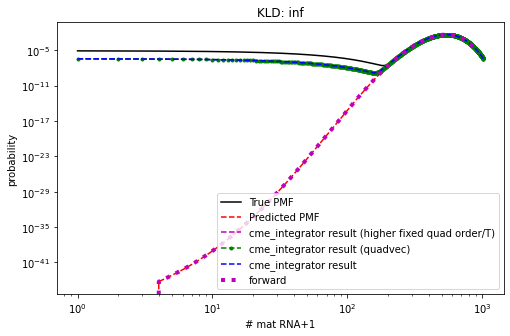

In [109]:
test_list[i__]
# as an example: 
param_list,y_list = rt1.load_training_data(test_list)


p1 = param_list[i__:i__+1]
y1 = [y_list[i__]]


# tt.plot_PMF(p1,y1,model,npdf,get_ypred_at_RT,kld=True) 
ax = plot_PMF_(p1,y1,model,npdf,YPRED_FUN,kld=True)

# print(p1)
p1_lin = 10**np.asarray(p1[0])
MU, VAR, STD, xmax = gd.get_moments(p1_lin)

y = cme_integrator(p1_lin,xmax+100,quad_order=100,fixed_quad_T=30)
ax.plot(np.arange(len(y))+1,y,'m--',label='cme_integrator result (higher fixed quad order/T)')
y = cme_integrator(p1_lin,xmax+100,method='quad_vec')
ax.plot(np.arange(len(y))+1,y,'g.--',label='cme_integrator result (quadvec)')
y = cme_integrator(p1_lin,xmax+100)
ax.plot(np.arange(len(y))+1,y,'b--',label='cme_integrator result')

# print(y[0])
print('weights')
print(model.forward(p1)[0])
ax.plot(np.arange(xmax+1)+1,YPRED_FUN(p1[0],npdf,model.forward(p1)[0]).detach().numpy(),'m:',label='forward',linewidth=4)
_=ax.legend()

# gd.cme_integrator
# ax=plt.gca()
# g1 = plt.gca()
# g1.set_yscale('log')

In [ ]:
model.forward(p1)[0]

In [ ]:
p1

yeah it looks like trash... but it gets about 99% of the probability density right.

In [ ]:
model.forward(p1)[0][-1]


In [ ]:
grid = generate_grid(npdf,torch.tensor(VAR),torch.tensor(MU))

In [ ]:
grid

In [ ]:
model.forward(p1)

In [ ]:
get_ypred_at_RT(p1[0],npdf,model.forward(p1)[0])

In [ ]:
model.forward(p1)

In [38]:
from scipy.fft import irfft
import scipy
from scipy import integrate, stats
def cme_integrator(p,lm,method='fixed_quad',fixed_quad_T=10,quad_order=60,quad_vec_T=np.inf):
    b,bet,gam = p

    #initialize the generating function evaluation points
    mx = lm//2 + 1
    l = np.arange(mx)
    g = np.exp(-2j*np.pi*l/lm)-1

    #define function to integrate by quadrature.
    # print(g[1])
    # print(g[1])
    # print(g.shape)
#     fun = lambda x: INTFUN(x,g,b,bet,gam)
    if method=='quad_vec':
        fun = lambda x: INTFUN(x,g,b,bet,gam)
        T = quad_vec_T*(1/bet+1/gam+1)
        gf = scipy.integrate.quad_vec(fun,0,T)[0]
    if method=='fixed_quad':
        g = g[:,np.newaxis]
        fun = lambda x: INTFUN(x,g,b,bet,gam)
        T = fixed_quad_T*(1/bet+1/gam+1)
        gf = scipy.integrate.fixed_quad(fun,0,T,n=quad_order)[0]
    gf = np.exp(gf) #gf can be multiplied by k in the argument, but this is not relevant for the 3-parameter input.
    Pss = irfft(gf, n=lm)
    EPS=1e-16
    Pss[Pss<EPS]=EPS
    Pss = np.abs(Pss)/np.sum(np.abs(Pss)) #always has to be positive...
    return Pss

def INTFUN(x,g_,b,bet,gam):
    """
    Computes the Singh-Bokes integrand at time x. Used for numerical quadrature in cme_integrator.
    """
    if not np.isclose(bet,gam): #compute weights for the ODE solution.
        f = b*bet/(bet-gam)
        U = g_*f*(-np.exp(-bet*x)+np.exp(-gam*x))
    else:
        U = np.exp(-bet*x)*(bet * g_ *b* x)
    return U/(1-U)



In [56]:
np.isclose(46.95052,43.409775)

False

In [57]:
p1_lin

NameError: name 'p1_lin' is not defined

In [58]:
# MU, VAR, STD, xmax = 

In [59]:
print(rt1.get_moments(10**p1[0]))

(tensor(9.1140), tensor(1349.7853), tensor(36.7394), tensor(157, dtype=torch.int32))


In [40]:
def plot_PMF_(p_list,y_list,model,npdf,get_ypred_at_RT,kld=True):
    '''Plots predicted and true PMF for given parameter, ykerlist and ylist (one p, yker, y in each list)'''

    f1,ax1 = plt.subplots(1,1,figsize=(8,5))
    y_pred = rt1.get_predicted_PMF(p_list=p_list,
                                y_list=y_list,npdf=npdf,position=0,model=model,get_ypred_at_RT = get_ypred_at_RT)

#     print(y_pred)
    Y = y_pred.detach().numpy()
    print(Y[:10])
    y = y_list[0].detach().numpy()
    print(y[:10])

    print(len(y))
    x = np.arange(len(y))
    ax1.plot(x+1,y,'k-',label='True PMF')
    ax1.plot(x+1,Y,'r--',label='Predicted PMF')

    ax1.set_xlabel('# mat RNA+1')
    ax1.set_ylabel('probability')

    ax1.set_yscale('log')
    ax1.set_xscale('log')
#     ax1.set_ylim([1e-8,1])

    if kld == True:
        kld_ = -np.sum(y*np.log(Y/y))
        ax1.set_title(f'KLD: {kld_:.5f}')
#     plt.show()
    return ax1